In [2]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import CalculatedFieldSubroutines as cfs

from pandasgui import show

In [3]:
gmID_df = pd.read_csv( '/home/rcoldren_linux/Desktop/Data/groupMetadataID_list_updated.csv' )

In [4]:
gmID_list = gmID_df[ 'groupMetadataID' ].tolist()

In [5]:
desktop_path = '/home/rcoldren_linux/Desktop'

In [6]:
topic = '/apollo/canbus/chassis'

dir_friendly_topic = topic.replace( '/', '_' )

chassis_dfs = []

for gmID in gmID_list:

    csv_name = gmID + dir_friendly_topic

    temp_df = pd.read_csv( f'{ desktop_path }/Raw_Data/{ gmID }/{ dir_friendly_topic }/{ csv_name }.csv' )

    temp_df = temp_df.sort_values( 'time' )

    chassis_dfs.append( temp_df )

In [7]:
for index, df in enumerate( chassis_dfs ):

    df = df[ [ 'time', 'groupMetadataID', 'drivingMode', 'speedMps', 'throttlePercentage', 'steeringPercentage', 'brakePercentage',
              'signal.turnSignal' ] ]

    chassis_dfs[ index ] = df

In [8]:
topic = '/apollo/sensor/gnss/best_pose'

dir_friendly_topic = topic.replace( '/', '_' )

best_pose_dfs = []

for gmID in gmID_list:

    csv_name = gmID + dir_friendly_topic

    temp_df = pd.read_csv( f'{ desktop_path }/Raw_Data/{ gmID }/{ dir_friendly_topic }/{ csv_name }.csv' )

    temp_df = temp_df.sort_values( 'time' )

    best_pose_dfs.append( temp_df )

In [9]:
for index, df in enumerate( best_pose_dfs ):

    df = df[ [ 'time', 'groupMetadataID', 'latitude', 'longitude', 'latitudeStdDev', 'longitudeStdDev', 'numSatsInSolution' ] ]

    best_pose_dfs[ index ] = df

In [10]:
for chassis_df, best_pose_df in zip( chassis_dfs, best_pose_dfs ):

    cfs.ChassisBestPoseMatchedTime( chassis_df, best_pose_df )

/home/rcoldren_linux/Desktop/TDMprivate/code/Unfinished Code/CalculatedFieldSubroutines.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  same_gmID_best_pose_df[ 'ChassisBestPoseMatchedTime' ] = same_gmID_best_pose_df[ 'time' ]


In [11]:
for df in chassis_dfs:

    cfs.BinaryDrivingMode( df )

    cfs.TernaryDrivingModeTransition( df )

In [12]:
for df in best_pose_dfs:

    cfs.LatLonTotalStdDev( df )

/home/rcoldren_linux/Desktop/TDMprivate/code/Unfinished Code/CalculatedFieldSubroutines.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_pose_df[ 'LatLonTotalStdDev' ] = latlon_total_stddev_lst


In [13]:
merged_chassis_best_pose_dfs = []

for chassis_df, best_pose_df in zip( chassis_dfs, best_pose_dfs ):

    merged_chassis_best_pose_df = pd.merge( chassis_df, best_pose_df, on = 'ChassisBestPoseMatchedTime', how = 'inner' )

    merged_chassis_best_pose_dfs.append( merged_chassis_best_pose_df )

In [14]:
all_merged_chassis_best_pose_dfs = pd.concat( merged_chassis_best_pose_dfs )

In [15]:
manual_df = all_merged_chassis_best_pose_dfs[ all_merged_chassis_best_pose_dfs[ 'BinaryDrivingMode'] == 0 ]

automatic_df = all_merged_chassis_best_pose_dfs[ all_merged_chassis_best_pose_dfs[ 'BinaryDrivingMode'] == 1 ]

disengagements_df = all_merged_chassis_best_pose_dfs[ all_merged_chassis_best_pose_dfs[ 'TernaryDrivingModeTransition' ] == -1 ]

reengagements_df = all_merged_chassis_best_pose_dfs[ all_merged_chassis_best_pose_dfs[ 'TernaryDrivingModeTransition' ] == 1 ]

In [16]:
group_by_numsat = all_merged_chassis_best_pose_dfs.groupby( 'TernaryDrivingModeTransition' )

group_by_numsat.agg( { 'LatLonTotalStdDev': [ 'mean', 'median', 'max', 'count' ] } )

LatLonTotalStdDev                                
                                          mean    median         max     count
TernaryDrivingModeTransition                                                  
-1                                    0.501751  0.022572  173.560116      2217
 0                                    0.287376  0.021209  481.737800  14602681
 1                                    0.284929  0.021292   41.327991      2217

In [17]:
all_latlontotalstddev_array = np.array( all_merged_chassis_best_pose_dfs[ 'LatLonTotalStdDev' ] )

manual_latlontotalstddev_array = np.array( manual_df[ 'LatLonTotalStdDev' ] )

automatic_latlontotalstddev_array = np.array( automatic_df[ 'LatLonTotalStdDev' ] )

disengagements_latlontotalstddev_array = np.array( disengagements_df[ 'LatLonTotalStdDev' ] )

reengagements_latlontotalstddev_array = np.array( reengagements_df[ 'LatLonTotalStdDev' ] )

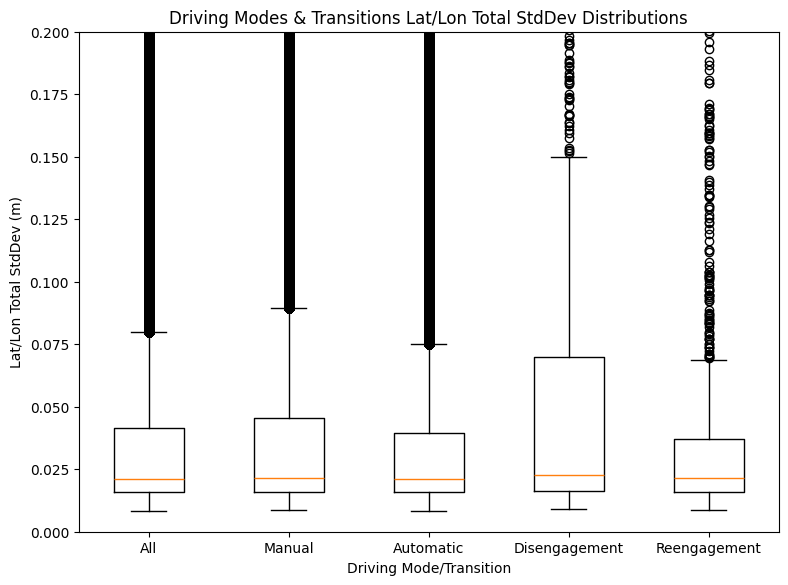

In [18]:
fig = plt.figure( figsize = ( 7, 5 ) )

ax = fig.add_axes( [ 0, 0, 1, 1 ] )

bp = ax.boxplot( [ all_latlontotalstddev_array, manual_latlontotalstddev_array, automatic_latlontotalstddev_array, 
                  disengagements_latlontotalstddev_array, reengagements_latlontotalstddev_array ],
                 tick_labels = [ 'All', 'Manual', 'Automatic', 'Disengagement', 'Reengagement' ] )

ax.set_ylim( 0, 0.2 )

ax.set_xlabel( 'Driving Mode/Transition' )

ax.set_ylabel( 'Lat/Lon Total StdDev (m)' )

ax.set_title( 'Driving Modes & Transitions Lat/Lon Total StdDev Distributions' )

plt.show()

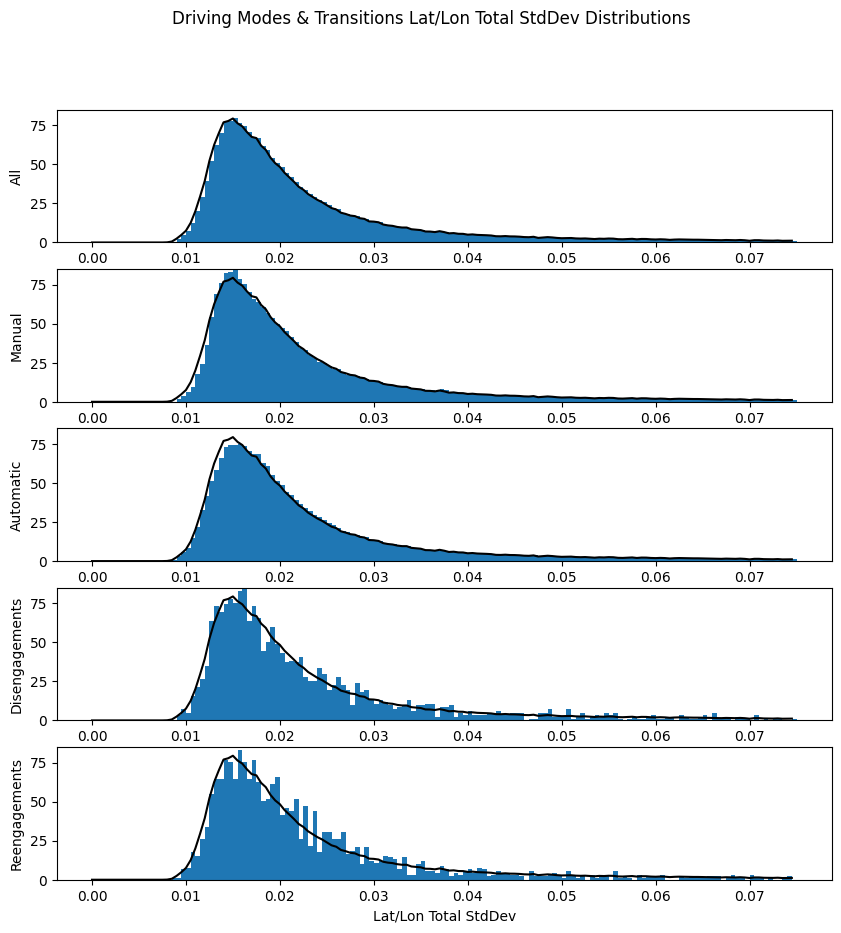

In [29]:
fig, ( ax1, ax2, ax3, ax4, ax5 ) = plt.subplots( 5 )

fig.suptitle( 'Driving Modes & Transitions Lat/Lon Total StdDev Distributions' )


y, x, z = ax1.hist( all_latlontotalstddev_array, bins = 150, range = ( 0, 0.075 ), density = True )

ax1.plot( x[ 0 : -1 ], y, color = 'k' )

ax1.set_ylim( 0, 85 )

ax1.set_ylabel( 'All' )


ax2.hist( manual_latlontotalstddev_array, bins = 150, range = ( 0, 0.075 ), density = True )

ax2.plot( x[ 0 : -1 ], y, color = 'k' )

ax2.set_ylim( 0, 85 )

ax2.set_ylabel( 'Manual' )


ax3.hist( automatic_latlontotalstddev_array, bins = 150, range = ( 0, 0.075 ), density = True )

ax3.plot( x[ 0 : -1 ], y, color = 'k' )

ax3.set_ylim( 0, 85 )

ax3.set_ylabel( 'Automatic' )


ax4.hist( disengagements_latlontotalstddev_array, bins = 150, range = ( 0, 0.075 ), density = True )

ax4.plot( x[ 0 : -1 ], y, color = 'k' )

ax4.set_ylim( 0, 85 )

ax4.set_ylabel( 'Disengagements' )


ax5.hist( reengagements_latlontotalstddev_array, bins = 150, range = ( 0, 0.075 ), density = True )

ax5.plot( x[ 0 : -1 ], y, color = 'k' )

ax5.set_ylim( 0, 85 )

ax5.set_ylabel( 'Reengagements' )

ax5.set_xlabel( 'Lat/Lon Total StdDev' )


fig.set_figheight( 10 )

fig.set_figwidth( 10 )

plt.show()

In [22]:
all_numSatsInSolution_array = np.array( all_merged_chassis_best_pose_dfs[ 'numSatsInSolution' ] )

manual_numSatsInSolution_array = np.array( manual_df[ 'numSatsInSolution' ] )

automatic_numSatsInSolution_array = np.array( automatic_df[ 'numSatsInSolution' ] )

disengagements_numSatsInSolution_array = np.array( disengagements_df[ 'numSatsInSolution' ] )

reengagements_numSatsInSolution_array = np.array( reengagements_df[ 'numSatsInSolution' ] )

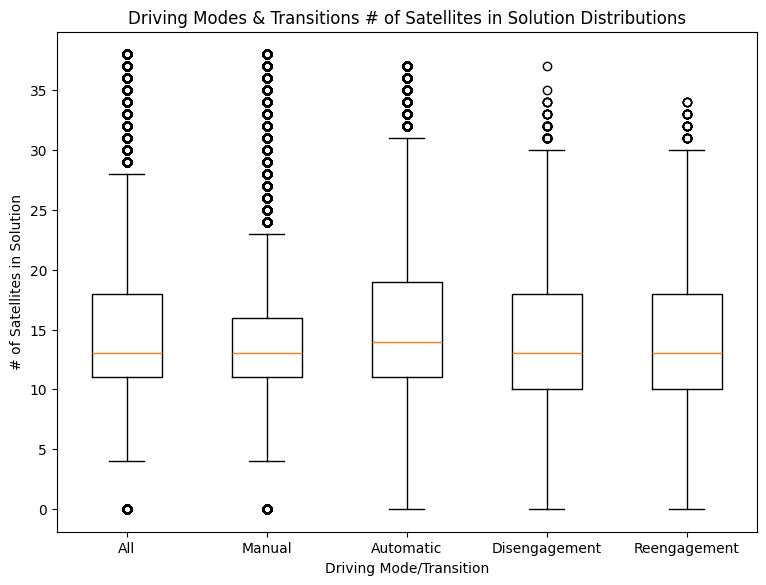

In [23]:
fig = plt.figure( figsize = ( 7, 5 ) )

ax = fig.add_axes( [ 0, 0, 1, 1 ] )

bp = ax.boxplot( [ all_numSatsInSolution_array, manual_numSatsInSolution_array, automatic_numSatsInSolution_array, 
                  disengagements_numSatsInSolution_array, reengagements_numSatsInSolution_array ],
                 tick_labels = [ 'All', 'Manual', 'Automatic', 'Disengagement', 'Reengagement' ] )

#ax.set_ylim( 0, 0.2 )

ax.set_xlabel( 'Driving Mode/Transition' )

ax.set_ylabel( '# of Satellites in Solution' )

ax.set_title( 'Driving Modes & Transitions # of Satellites in Solution Distributions' )

plt.show()

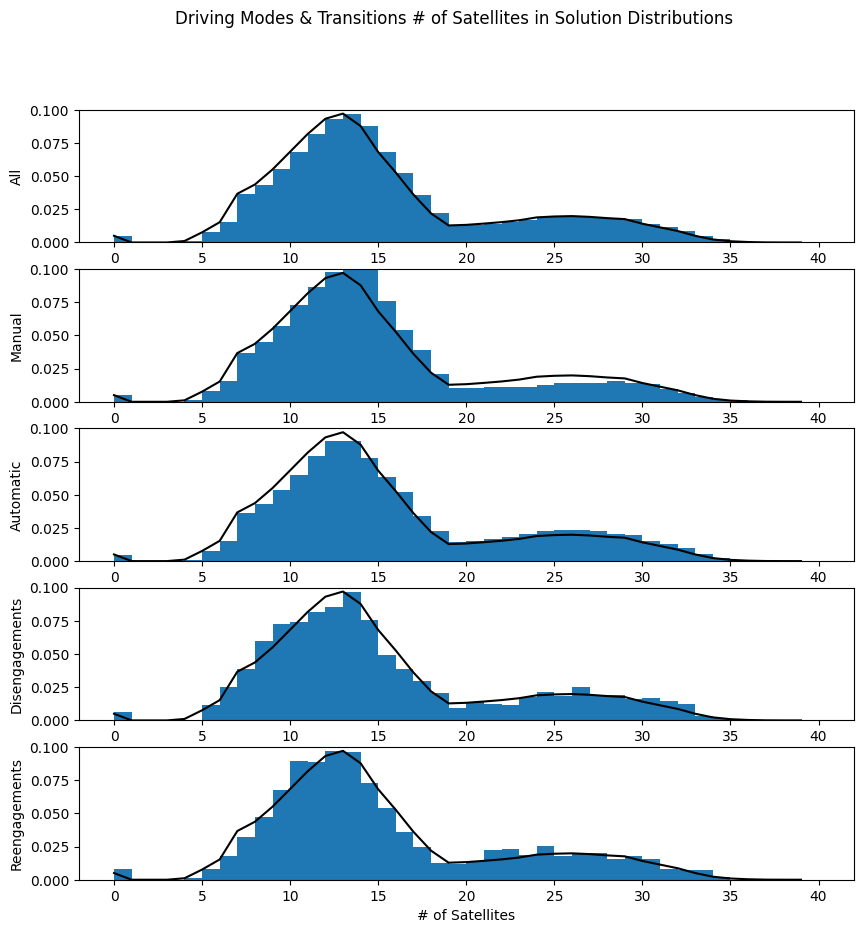

In [24]:
fig, ( ax1, ax2, ax3, ax4, ax5 ) = plt.subplots( 5 )

fig.suptitle( 'Driving Modes & Transitions # of Satellites in Solution Distributions' )


y, x, z = ax1.hist( all_numSatsInSolution_array, bins = 40, range = ( 0, 40 ), density = True )

ax1.plot( x[ 0 : -1 ], y, color = 'k' )

ax1.set_ylim( 0, 0.1 )

ax1.set_ylabel( 'All' )


ax2.hist( manual_numSatsInSolution_array, bins = 40, range = ( 0, 40 ), density = True )

ax2.plot( x[ 0 : -1 ], y, color = 'k' )

ax2.set_ylim( 0, 0.1 )

ax2.set_ylabel( 'Manual' )


ax3.hist( automatic_numSatsInSolution_array, bins = 40, range = ( 0, 40 ), density = True )

ax3.plot( x[ 0 : -1 ], y, color = 'k' )

ax3.set_ylim( 0, 0.1 )

ax3.set_ylabel( 'Automatic' )


ax4.hist( disengagements_numSatsInSolution_array, bins = 40, range = ( 0, 40 ), density = True )

ax4.plot( x[ 0 : -1 ], y, color = 'k' )

ax4.set_ylim( 0, 0.1 )

ax4.set_ylabel( 'Disengagements' )


ax5.hist( reengagements_numSatsInSolution_array, bins = 40, range = ( 0, 40 ), density = True )

ax5.plot( x[ 0 : -1 ], y, color = 'k' )

ax5.set_ylim( 0, 0.1 )

ax5.set_ylabel( 'Reengagements' )

ax5.set_xlabel( '# of Satellites' )


fig.set_figheight( 10 )

fig.set_figwidth( 10 )

plt.show()